# 1D data processing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv

from pysemtools.datatypes.coef import get_derivative_matrix

## Redeclare functions that are part of coef for 2d and 3d
here we are not creating a coef object, although we could with some modifications

In [2]:
def dudrst(field, dr):

    nelv = field.shape[0]
    lx = field.shape[3] # This is not a mistake. This is how the data is read
    ly = field.shape[2]
    lz = field.shape[1]

    dudrst = np.zeros_like(field, dtype=np.double)

    for e in range(0, nelv):
        tmp = field[e,:,:,:].reshape(-1,1)
        dtmp = dr@tmp
        dudrst[e,:,:,:] = dtmp.reshape((lz,ly,lx))

    return dudrst

def dudxyz(field, dr,  drdx):

    '''Here we just use the chain rule. We have the derivative of the field wrt r and the derivative of r wrt x.'''

    nelv = field.shape[0]
    lx = field.shape[3] # This is not a mistake. This is how the data is read
    ly = field.shape[2]
    lz = field.shape[1]
    dudxyz = np.zeros_like(field, dtype=np.double)

    # dfdr
    dfdr = dudrst(field, dr)

    #dfdx = dfdr * drdx
    for e in range(0, nelv):
        for k in range(0, lz):
            for j in range(0, ly):
                for i in range(0, lx):
                    dudxyz[e,k,j,i] = ( dfdr[e, k, j, i] * drdx[e, k, j, i] )

    return dudxyz

## Boiler plate code 

 In practice here we would initialize a mesh and coef object.
 they can only be defined for 2d and 3d currently, therefore
 we do it manually in this example.


In [3]:
# File data
fname = 'data/space_avg_xz_mean.csv'
file = open(fname)
data = np.array(list(csv.reader(file)), dtype=np.double)

# Domain data (YOU SHOULD GIVE THIS INFORMATION SINCE IT IS NOT IN THE HEADER OF THE FILE)
lx = 8
gdim = 1
nelv = int(data.shape[0]/lx)

# Mesh data: Reshape the data to make it consistent with other examples
y = data[:,0].reshape((nelv, 1, 1, lx))

# Coef data:
## Get the derivative matrix wrt r
ds, _, _, _ = get_derivative_matrix( lx , gdim)
## Find the jacobian (we do not really have a jacobian, but I write it so for consistency)
dyds = dudrst(y, ds)
## Find the inverse of the jacobian (Again, this is not a matrix, no need to do a matrix inversion)
dsdy = 1/dyds

## Data processing

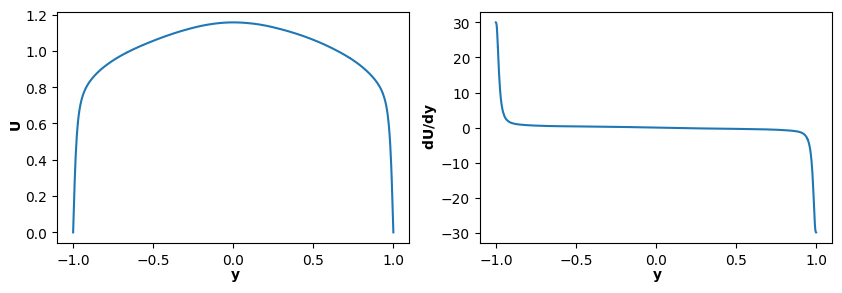

In [4]:
# This is the field you want to process (note the shape)
u = data[:,1].reshape((nelv, 1, 1, lx)) # Note that I am reshaping the data to be consistent with other examples.
# Get the derivative like this
dudy = dudxyz(u, ds, dsdy)

# For plotting, just reshape:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(y.reshape(lx*nelv*gdim), u.reshape(lx*nelv*gdim))
ax[1].plot(y.reshape(lx*nelv*gdim), dudy.reshape(lx*nelv*gdim))
ax[0].set_xlabel(r' $ \mathbf{y} $',labelpad=1)
ax[0].set_ylabel(r' $ \mathbf{U} $',labelpad=1)
ax[1].set_xlabel(r' $ \mathbf{y} $',labelpad=1)
ax[1].set_ylabel(r' $ \mathbf{dU/dy} $',labelpad=1)
plt.show()

## For completion, get the derivatives with python. For some reason it does not look good

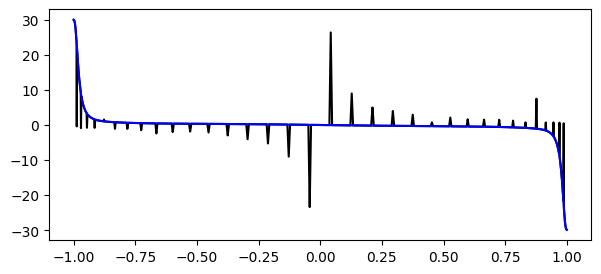

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
dudy_python = np.gradient(data[:,1], data[:,0],edge_order=2)
ax.plot(data[:,0], dudy_python, '-k')
ax.plot(y.reshape(lx*nelv*gdim), dudy.reshape(lx*nelv*gdim), '-b')
plt.show()